In [1]:
!pip install boto3

  Using cached boto3-1.22.8-py3-none-any.whl (132 kB)
  Using cached jmespath-1.0.0-py3-none-any.whl (23 kB)
  Using cached botocore-1.25.8-py3-none-any.whl (8.7 MB)
  Using cached s3transfer-0.5.2-py3-none-any.whl (79 kB)


In [2]:
!pip install astropy

  Using cached astropy-5.0.4-cp39-cp39-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (11.1 MB)
  Using cached pyerfa-2.0.0.1-cp39-cp39-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_12_x86_64.manylinux2010_x86_64.whl (742 kB)


In [3]:
!pip install sfdmap

  Using cached sfdmap-0.1.1-py3-none-any.whl


In [4]:
# imports
import pandas as pd
import numpy as np
import os
import sys
import pickle
import boto3

# random seed
seed = 42
np.random.seed(seed)

# local files paths
local_home_dir_path = os.path.expanduser("~")
local_work_dir_path = os.path.join(local_home_dir_path, 'git')
local_code_dir_path = os.path.join(local_work_dir_path , 'code')

# S3 file paths
endpoint_url = 'https://s3-west.nrp-nautilus.io'
bucket_name = 'tau-astro'
prefix = 'almogh'
s3_work_dir_path = os.path.join(prefix, 'workdir3')
s3_saves_dir_path = os.path.join(s3_work_dir_path , 'model_saves')
s3_data_dir_path = os.path.join(s3_work_dir_path , 'data')
s3_final_table_csv_path = os.path.join(s3_data_dir_path, 'SDSS_DR16_all.csv')
s3_data_ver_dir_path = os.path.join(s3_data_dir_path,'100K_V2')

s3_client = boto3.client("s3", endpoint_url=endpoint_url)

# adding code folder to path
sys.path.insert(1, local_code_dir_path)
from s3 import to_s3_npy, to_s3_pkl, from_s3_npy, from_s3_pkl, to_s3_fig

In [5]:
gs = from_s3_pkl(s3_client, bucket_name, os.path.join(s3_data_ver_dir_path,'gs.pkl'))

loading from uri: s3://tau-astro/almogh/workdir3/data/100K_V2/gs.pkl


In [6]:
specs = [from_s3_npy(s3_client, bucket_name, os.path.join(s3_data_ver_dir_path,'spec{0}.npy'.format(i))) for i in range(8)]

loading from uri: s3://tau-astro/almogh/workdir3/data/100K_V2/spec0.npy
loading from uri: s3://tau-astro/almogh/workdir3/data/100K_V2/spec1.npy
loading from uri: s3://tau-astro/almogh/workdir3/data/100K_V2/spec2.npy
loading from uri: s3://tau-astro/almogh/workdir3/data/100K_V2/spec3.npy
loading from uri: s3://tau-astro/almogh/workdir3/data/100K_V2/spec4.npy
loading from uri: s3://tau-astro/almogh/workdir3/data/100K_V2/spec5.npy
loading from uri: s3://tau-astro/almogh/workdir3/data/100K_V2/spec6.npy
loading from uri: s3://tau-astro/almogh/workdir3/data/100K_V2/spec7.npy


In [7]:
L = specs[0].shape[1]

In [8]:
N = 0
for spec in specs:
    N+=spec.shape[0]

In [9]:
for i in range(len(specs)):
    del specs[0]
del specs

In [10]:
specs = np.zeros(shape=(N,L), dtype=np.float32)

In [11]:
idx = 0
for i in range(8):
    spec = from_s3_npy(s3_client, bucket_name, os.path.join(s3_data_ver_dir_path,'spec{0}.npy'.format(i)))
    specs[idx:(idx+spec.shape[0]),:] = spec
    idx += spec.shape[0]
    del spec

loading from uri: s3://tau-astro/almogh/workdir3/data/100K_V2/spec0.npy
loading from uri: s3://tau-astro/almogh/workdir3/data/100K_V2/spec1.npy
loading from uri: s3://tau-astro/almogh/workdir3/data/100K_V2/spec2.npy
loading from uri: s3://tau-astro/almogh/workdir3/data/100K_V2/spec3.npy
loading from uri: s3://tau-astro/almogh/workdir3/data/100K_V2/spec4.npy
loading from uri: s3://tau-astro/almogh/workdir3/data/100K_V2/spec5.npy
loading from uri: s3://tau-astro/almogh/workdir3/data/100K_V2/spec6.npy
loading from uri: s3://tau-astro/almogh/workdir3/data/100K_V2/spec7.npy


In [12]:
to_s3_npy(specs, s3_client, bucket_name, os.path.join(s3_data_ver_dir_path,'spec.npy'))

saving to uri: s3://tau-astro/almogh/workdir3/data/100K_V2/spec.npy


True

# Choosing a common wavelength grid

In [14]:
wl_grid = from_s3_npy(s3_client, bucket_name, 'almogh/workdir3/data/wl_grid.npy')

loading from uri: s3://tau-astro/almogh/workdir3/data/wl_grid.npy


In [24]:
gs['waveMin_rest'] = np.divide(gs.waveMin,1+gs.z)
gs['waveMax_rest'] = np.divide(gs.waveMax,1+gs.z)

In [26]:
gs_sorted = gs.sort_values(by=['waveMin_rest','waveMax_rest'])

In [15]:
# load data
print('Loading data and creating dataset')
X = specs
original_wl_str = 'Original wavelength grid: {0}-{1} [A], length={2}.'.format(min(wl_grid),max(wl_grid),len(wl_grid))
print(original_wl_str)

# get the limits of every sample
X_valid = ~np.isnan(X)
sample_i_start = np.argmax(X_valid, axis=1)
sample_i_end = X.shape[1] - np.argmax(np.fliplr(X_valid), axis=1) # non inclusive
support = X_valid.sum(axis=0)/X_valid.shape[0]

# make sure no holes
assert all([i<=2 for i in np.sum(np.abs(np.diff(X_valid, axis=1)), axis=1)]), 'some rows in X contain fragmented spans!'

Loading data and creating dataset
Original wavelength grid: 1725.0-9762.5 [A], length=16076.


In [17]:
from matplotlib import pyplot as plt

New wavelength grid: 3400.0-8000.0 [A], length=9200.
Number of samples after filtering the slice: 111613


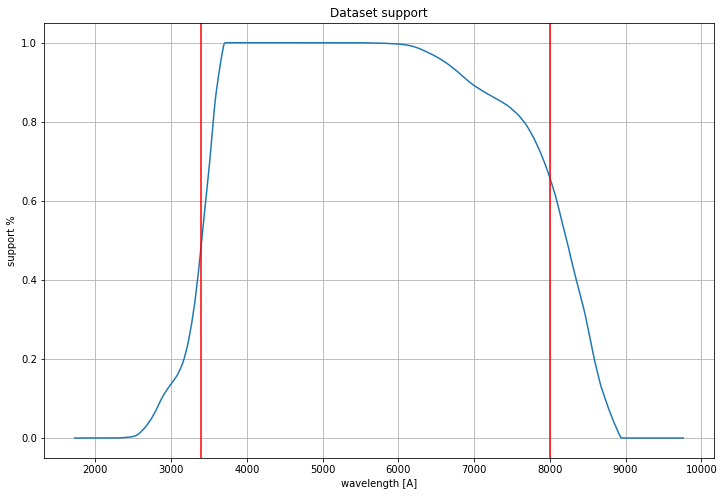

In [31]:
# wavelength grid limits
start_wl = 3400
end_wl = 8000
start_i = (np.abs(wl_grid - start_wl)).argmin()
end_i = (np.abs(wl_grid - end_wl)).argmin()
    
# limit indices (taking only a slice of the data with full support)
new_wl_str = 'New wavelength grid: {0}-{1} [A], length={2}.'.format(wl_grid[start_i],wl_grid[end_i],end_i-start_i)
print(new_wl_str)

# plot the support of the dataset
fig,ax = plt.subplots(figsize=(12,8))
ax.plot(wl_grid, support)
plt.grid()
plt.axvline(x=wl_grid[start_i], ymin=0, ymax=1, c='r')
plt.axvline(x=wl_grid[end_i], ymin=0, ymax=1, c='r')
ax.set_xlabel('wavelength [A]')
ax.set_ylabel('support %')
ax.set_title('Dataset support')

# taking only the samples with full support over the slice
I_slice = np.array([i for i in range(X_valid.shape[0]) if (sample_i_start[i]<=start_i and sample_i_end[i]>end_i)])
samples_str = 'Number of samples after filtering the slice: {0}'.format(len(I_slice))
print(samples_str)

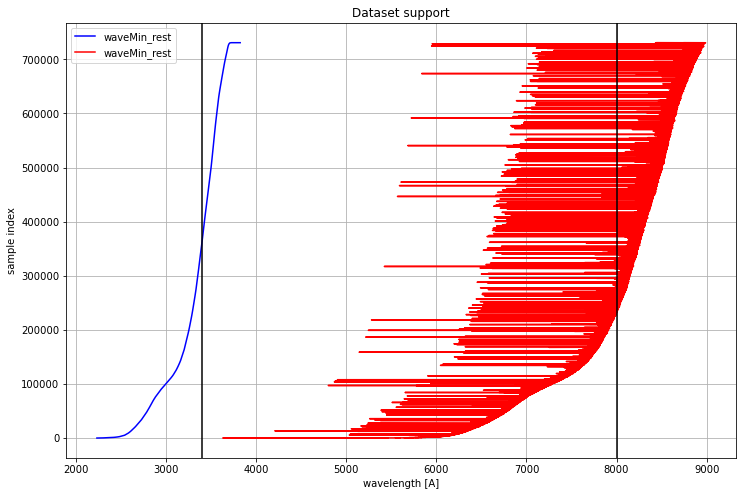

In [32]:
fig,ax = plt.subplots(figsize=(12,8))
ax.plot(gs_sorted['waveMin_rest'],np.arange(len(gs)),c='b',label='waveMin_rest')
ax.plot(gs_sorted['waveMax_rest'],np.arange(len(gs)),c='r',label='waveMin_rest')
plt.grid()
plt.axvline(x=wl_grid[start_i], ymin=0, ymax=1, c='k')
plt.axvline(x=wl_grid[end_i], ymin=0, ymax=1, c='k')
ax.set_xlabel('wavelength [A]')
ax.set_ylabel('sample index')
ax.set_title('Dataset support')
plt.legend()

In [33]:
s3_new_data_ver_dir_path = os.path.join(s3_data_dir_path,'100K_V3')

In [34]:
to_s3_pkl(gs.loc[I_slice], s3_client, bucket_name, os.path.join(s3_new_data_ver_dir_path,'gs_100K_V3.pkl'))
to_s3_npy(wl_grid[start_i:end_i], s3_client, bucket_name, os.path.join(s3_new_data_ver_dir_path,'wl_100K_V3.npy'))

saving to uri: s3://tau-astro/almogh/workdir3/data/100K_V3/gs_100K_V3.pkl
saving to uri: s3://tau-astro/almogh/workdir3/data/100K_V3/wl_100K_V3.npy


True

In [35]:
to_s3_pkl(gs.loc[I_slice].sort_values(by='snMedian', ascending=False).iloc[:10000], s3_client, bucket_name, os.path.join(s3_new_data_ver_dir_path,'gs_100K_V3_top10K_SNR.pkl'))

saving to uri: s3://tau-astro/almogh/workdir3/data/100K_V3/gs_100K_V3_top10K_SNR.pkl


True

In [36]:
to_s3_pkl(gs.sort_values(by='snMedian', ascending=False).iloc[:10000], s3_client, bucket_name, os.path.join(s3_new_data_ver_dir_path,'gs_top10K_SNR.pkl'))

saving to uri: s3://tau-astro/almogh/workdir3/data/100K_V3/gs_top10K_SNR.pkl


True